In [ ]:
import os, time, csv, json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from dataloader import VADDataset, make_loader 
# from model import DepthwiseSeparable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class DepthwiseSeparable(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.depthwiseConv = nn.Conv2d(c_in, c_in, kernel_size=3, padding=1, groups=c_in, bias=False)
        self.pointwiseConv = nn.Conv2d(c_in, c_out, kernel_size=1, bias=False)
        self.b_norm = nn.BatchNorm2d(c_out)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.depthwiseConv(x)
        x = self.pointwiseConv(x)
        x = self.b_norm(x)
        return self.relu(x)

In [ ]:
class TinyVAD(nn.Module):
    def __init__(self, n_mels=40):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
        self.b1 = DepthwiseSeparable(16, 24)
        self.b2 = DepthwiseSeparable(24, 32)
        self.b3 = DepthwiseSeparable(32, 48)
        self.head = nn.Conv2d(48, 1, kernel_size=1)  # [B,1,M,T]

        self.n_mels = n_mels

    def forward(self, x):  # x: [B, 1, n_mels(=40), T]
        x = self.stem(x)
        x = self.b1(x) 
        x = self.b2(x) 
        x = self.b3(x)  # [B,48,M,T]
        x = self.head(x)                                 # [B, 1, M, T]
        x = x.mean(dim=2)                                # 沿 mel 平均 -> [B, 1, T]
        return x.squeeze(1)                              # [B, T]

#DataLoader
def build_loaders(batch_size=16, num_workers=0, shuffle_train=True):
    train_ds, train_dl = make_loader(split="train", batch_size=batch_size,
                                     shuffle=shuffle_train, num_workers=num_workers)
    valid_ds, valid_dl = make_loader(split="valid", batch_size=batch_size,
                                     shuffle=False, num_workers=num_workers)
    return train_ds, train_dl, valid_ds, valid_dl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
epochs       = 30
batch_size   = 8
lr           = 1e-3
weight_decay = 1e-4
ckpt_dir     = Path("./checkpoints")
ckpt_dir.mkdir(parents=True, exist_ok=True)

#DataLoader
train_ds, train_dl, valid_ds, valid_dl = build_loaders(batch_size=batch_size, num_workers=0)

model = TinyVAD(n_mels=40).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.BCEWithLogitsLoss()  # labels 要轉 float

In [ ]:
train_losses, valid_losses = [], []
best_valid = float("inf")

In [ ]:
def run_epoch(model, loader, optimizer=None):
    if optimizer is not None:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_frames = 0
    
    for batch in loader:
        x = batch["feat"].to(device)          # [B, 40, T]
        y = batch["label"].float().to(device) # [B, T]

        # [B, 40, T] -> [B, 1, 40, T]
        x = x.unsqueeze(1)

        logits = model(x) # [B, T]
        loss = criterion(logits, y)

        if optimizer:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

        B, T = y.shape
        total_loss   += loss.item() * B * T
        total_frames += B * T

    avg_loss = total_loss / max(1, total_frames)
    return avg_loss

[01/30] train_loss=0.226873  valid_loss=0.189469  (289.4s)  | best_valid=0.189469
[02/30] train_loss=0.187011  valid_loss=0.180718  (239.6s)  | best_valid=0.180718
[03/30] train_loss=0.177242  valid_loss=0.170739  (239.8s)  | best_valid=0.170739
[04/30] train_loss=0.172894  valid_loss=0.167115  (236.0s)  | best_valid=0.167115
[05/30] train_loss=0.170148  valid_loss=0.167479  (237.5s)  | best_valid=0.167115
[06/30] train_loss=0.168589  valid_loss=0.173336  (239.8s)  | best_valid=0.167115
[07/30] train_loss=0.167545  valid_loss=0.161714  (232.9s)  | best_valid=0.161714
[08/30] train_loss=0.166472  valid_loss=0.161160  (231.2s)  | best_valid=0.161160
[09/30] train_loss=0.165690  valid_loss=0.159573  (233.9s)  | best_valid=0.159573
[10/30] train_loss=0.165293  valid_loss=0.163747  (232.5s)  | best_valid=0.159573
[11/30] train_loss=0.164442  valid_loss=0.159617  (233.7s)  | best_valid=0.159573
[12/30] train_loss=0.163867  valid_loss=0.161042  (234.6s)  | best_valid=0.159573
[13/30] train_lo

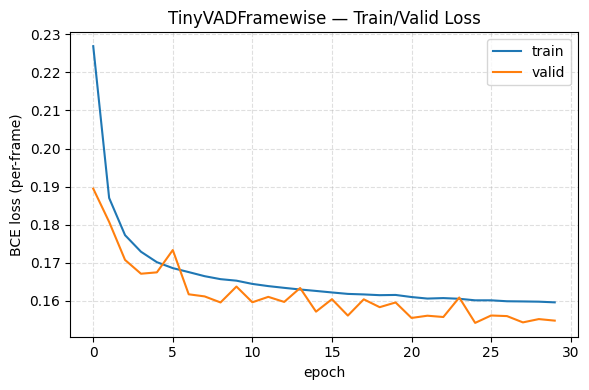

In [ ]:
for epoch in range(1, epochs + 1):
    t0 = time.time()
    train_loss = run_epoch(model, train_dl, optimizer=optimizer)
    valid_loss = run_epoch(model, valid_dl, optimizer=None)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # checkpoint（每個 epoch：last；若更好：best）
    ckpt_last = {
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "train_loss": train_loss,
        "valid_loss": valid_loss,
    }
    torch.save(ckpt_last, ckpt_dir / f"{epoch}_last.pt")

    if valid_loss < best_valid:
        best_valid = valid_loss
        torch.save(ckpt_last, ckpt_dir / f"{epoch}_best.pt")

    print(f"[{epoch:02d}/{epochs}] "
          f"train_loss={train_loss:.6f}  valid_loss={valid_loss:.6f}  "
          f"({time.time()-t0:.1f}s)  | best_valid={best_valid:.6f}")

# loss 曲線
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="valid")
plt.xlabel("epoch")
plt.ylabel("BCE loss (per-frame)")
plt.title("TinyVADFramewise — Train/Valid Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()